In [170]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from scipy.stats import chi2_contingency, kruskal
import os
import networkx as nx
import warnings
warnings.filterwarnings("ignore")
import matplotlib.patches as mpatches

In [171]:
base_path = "../data/full"
algo = "w_slpa"
patient_df = pd.read_csv("../../data/thesis/cll_broad_2022_clinical_data_thesis.csv")
mutation_df = pd.read_csv("../../data/thesis/cll_broad_2022_mutations_thesis.csv")
community_df = pd.read_csv(os.path.join(base_path, algo, "community_assignments.csv"))

In [172]:
# Assign communityId to patient_df based on overlapping rules
from collections import defaultdict

# Build mapping: patientId -> list of communityIds
comm_map = defaultdict(list)
for _, row in community_df.iterrows():
    comm_map[row['patientId']].append(row['communityId'])

def resolve_community(comms):
    comms_set = set(comms)
    if {1,2}.issubset(comms_set):
        return 1
    elif {2,3}.issubset(comms_set):
        return 2
    else:
        return comms[0] if comms else np.nan

patient_df['communityId'] = patient_df['patientId'].map(lambda pid: resolve_community(comm_map.get(pid, [])))
patient_df['communityId'] = patient_df['communityId'].astype('Int64')  # Use Int64 for nullable integers
print(patient_df[['patientId', 'communityId']].head())

    patientId  communityId
0  P-CRC-0001            0
1  P-CRC-0002            0
2  P-CRC-0003            0
3  P-CRC-0004            1
4  P-CRC-0005            1


In [173]:
columns = [
    'patientId', 
    'CLL_EPITYPE', 
    'MUTATION_COUNT', 
    'TUMOR_MOLECULAR_SUBTYPE',
    'AGE_SAMPLING', 
    'COHORT', 
    'IGHV_MUTATION_STATUS', 
    'SEX',
    'TREATMENT_AFTER_SAMPLING', 
    'communityId'
]
patient_df = patient_df[columns]
patient_df.head()
# patient_df.to_csv("patient_data_with_community.csv", index=False)

,patientId,CLL_EPITYPE,MUTATION_COUNT,TUMOR_MOLECULAR_SUBTYPE,AGE_SAMPLING,COHORT,IGHV_MUTATION_STATUS,SEX,TREATMENT_AFTER_SAMPLING,communityId
0,P-CRC-0001,n-CLL,26.0,U-CLL,46.0,UCSD,unmutated,Female,Chemo + Ab,0
1,P-CRC-0002,n-CLL,23.0,U-CLL,56.0,UCSD,unmutated,Male,Chemo + Ab,0
2,P-CRC-0003,n-CLL,7.0,U-CLL,63.0,UCSD,unmutated,Female,Chemo + Ab,0
3,P-CRC-0004,m-CLL,30.0,M-CLL,51.0,UCSD,mutated,Male,Chemo + Ab,1
4,P-CRC-0005,n-CLL,23.0,U-CLL,37.0,UCSD,unmutated,Male,Chemo + Ab,1


In [174]:
patient_df.isna().sum()

patientId                     0
CLL_EPITYPE                   0
MUTATION_COUNT              161
TUMOR_MOLECULAR_SUBTYPE     160
AGE_SAMPLING                  3
COHORT                        0
IGHV_MUTATION_STATUS         23
SEX                           3
TREATMENT_AFTER_SAMPLING    747
communityId                 135
dtype: int64

In [175]:
patient_df['communityId'].value_counts()

communityId
3    374
0    286
2    282
1     66
Name: count, dtype: Int64

Number of rows after dropping missing target: 1008
Feature matrix shape: (1008, 6), Target vector shape: (1008,)


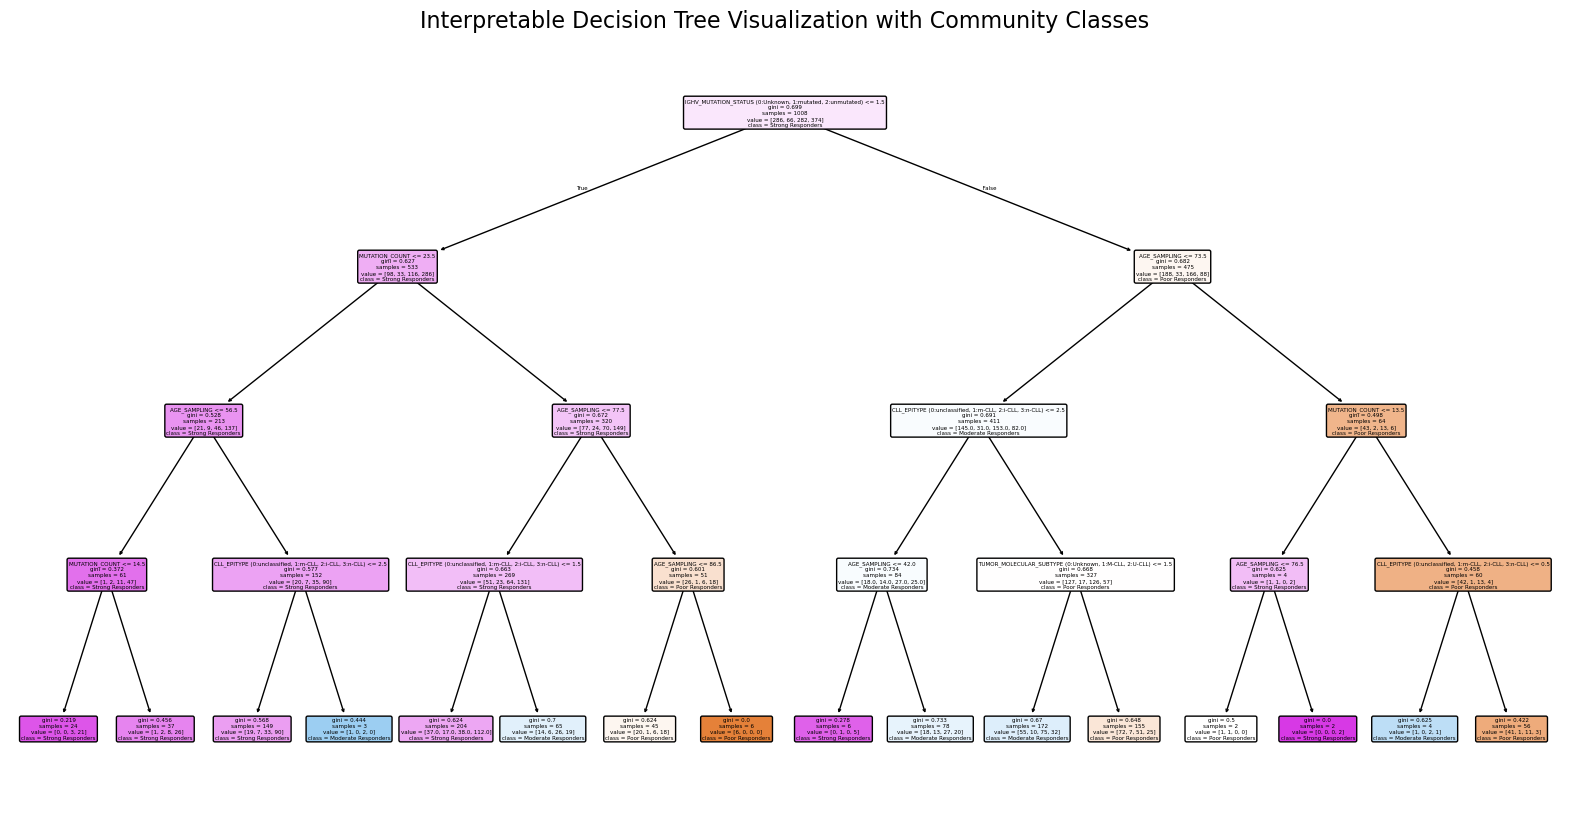

Decision tree trained and visualized.


In [176]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
import matplotlib.pyplot as plt

# Load the dataset
df = patient_df.copy(deep=True)

# Select relevant columns
features = ['AGE_SAMPLING', 'IGHV_MUTATION_STATUS', 'CLL_EPITYPE', 
            'TUMOR_MOLECULAR_SUBTYPE', 'MUTATION_COUNT', 'SEX']
target = 'communityId'

# Drop rows with missing target
df = df.dropna(subset=[target])
print(f"Number of rows after dropping missing target: {len(df)}")

#Specify the desired order for each categorical variable
category_orders = {
    'IGHV_MUTATION_STATUS': ['Unknown', 'mutated', 'unmutated'],
    'CLL_EPITYPE': ['unclassified', 'm-CLL', 'i-CLL', 'n-CLL'],
    'TUMOR_MOLECULAR_SUBTYPE': ['Unknown', 'M-CLL', 'U-CLL'],
    'SEX': ['Female', 'Male']
}

# Fill missing values for categorical columns with 'Unknown'
for col, order in category_orders.items():
    df[col] = df[col].fillna('Unknown')

# Fill missing values for numerical columns
for col in features:
    if col not in category_orders:
        df[col] = df[col].fillna(df[col].median())

# Ordinal encode categorical columns
ordinal_encoder = OrdinalEncoder(categories=[category_orders[col] for col in category_orders])
cat_features = list(category_orders.keys())
df[cat_features] = ordinal_encoder.fit_transform(df[cat_features])


X = df[features]
y = df[target].astype(int)
print(f"Feature matrix shape: {X.shape}, Target vector shape: {y.shape}")

# Store mapping for decoding
decode_maps = {col: category_orders[col] for col in cat_features}

class_map = {
    0: "Poor Responders",
    1: "Early Failure, Long Term Survival",
    2: "Moderate Responders",
    3: "Strong Responders"
}
# map the int to the class names
decode_maps[target] = [class_map[i] for i in sorted(class_map.keys())]

# Function to decode encoded values back to labels
def decode_feature(col, val):
    order = decode_maps[col]
    idx = int(val)
    if 0 <= idx < len(order):
        return order[idx]
    return "Unknown"

# Train decision tree
clf = DecisionTreeClassifier(max_depth=4, random_state=42)
clf.fit(X, y)

# Prepare display names for features for plot_tree
display_feature_names = []
for col in features:
    if col in decode_maps:
        display_feature_names.append(f"{col} (0:{decode_maps[col][0]}, 1:{decode_maps[col][1]}, 2:{decode_maps[col][2]})" if len(decode_maps[col])==3 else f"{col} ({', '.join([f'{i}:{v}' for i,v in enumerate(decode_maps[col])])})")
    else:
        display_feature_names.append(col)

# Visualize the decision tree with actual labels in feature names
plt.figure(figsize=(20, 10))
plot_tree(
    clf,
    feature_names=display_feature_names,
    class_names=[class_map[i] for i in sorted(y.unique())],
    filled=True,
    fontsize=4,
    rounded=True,
)

plt.title("Interpretable Decision Tree Visualization with Community Classes", fontsize=16)

plt.savefig("../../figures/decision_tree.png", dpi=300, bbox_inches='tight')
plt.show()
plt.close()

# Extract simplified decision rules
tree_rules = export_text(clf, feature_names=features)

print("Decision tree trained and visualized.")

# print("Rules extracted and saved to 'decision_tree_rules.txt'.")
# # Save rules to a text file
# with open("decision_tree_rules.txt", "w") as f:
#     f.write(tree_rules)

In [177]:
# use cross validation to get the best max depth
from sklearn.model_selection import cross_val_score
depths = range(3, 11)
cv_scores = []
for depth in depths:
    clf = DecisionTreeClassifier(max_depth=depth, random_state=42)
    scores = cross_val_score(clf, X, y, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())

# use the best depth
best_depth = depths[np.argmax(cv_scores)]
print(f"Best max depth: {best_depth}") 
print(f"Best score: {max(cv_scores):.2f}") 

Best max depth: 4
Best score: 0.44


In [178]:
import pandas as pd
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score

# Load the dataset
df = patient_df.copy(deep=True)

# Define the features to compare with communityId
features = [
    'IGHV_MUTATION_STATUS',
    'CLL_EPITYPE',
    'TUMOR_MOLECULAR_SUBTYPE',
    'COHORT',
    'SEX',
]

# Drop rows with missing communityId
df = df.dropna(subset=['communityId'])

# Initialize results dictionary
results = {'Feature': [], 'NMI': [], 'ARI': []}

# Compute NMI and ARI for each feature
for feature in features:
    # Drop rows with missing values in the feature
    valid_rows = df[[feature, 'communityId']].dropna()
    x = valid_rows[feature]
    y = valid_rows['communityId'].astype(int)

    # Encode categorical features
    if x.dtype == 'object':
        x = pd.factorize(x)[0]

    # Compute metrics
    nmi = normalized_mutual_info_score(y, x)
    ari = adjusted_rand_score(y, x)

    # Store results
    results['Feature'].append(feature)
    results['NMI'].append(round(nmi, 4))
    results['ARI'].append(round(ari, 4))

# Create DataFrame
metrics_df = pd.DataFrame(results)
metrics_df.set_index('Feature', inplace=True)

# Save to CSV
# metrics_df.to_csv("nmi_ari_metrics.csv")

# Generate LaTeX table
latex_table = metrics_df.to_latex(index=True, float_format="%.4f", column_format="|l|c|c|")

# Save LaTeX table to file
# with open("nmi_ari_metrics_table.tex", "w") as f:
#     f.write(latex_table)

metrics_df


,NMI,ARI
Feature,,
IGHV_MUTATION_STATUS,0.0761,0.0974
CLL_EPITYPE,0.0677,0.0821
TUMOR_MOLECULAR_SUBTYPE,0.0064,0.0006
COHORT,0.0764,0.0449
SEX,0.0070,0.0019
